Os dados do arquivo Brain, em anexo, referem-se ao peso do cérebro (g), tamanho da cabeça (cm3) de 237 adultos, identificados por sexo e grupo etário. O estudo teve por objetivo verificar se:

1) Há diferença no peso cerebral entre os sexos? E entre os grupos etários? ([TESTE DE HIPÓTESE] H0: há diferença / Ha: não há diferença)

2) O tamanho da cabeça é preditor do peso cerebral e, neste caso, há diferença nessa relação entre os sexos e entre os grupos etários? (Regressão Linear)

3) Estime o peso médio do cérebro de homens e de mulheres (pontual e intervalar). (estimação de parâmetros)

Interprete seus resultados e verifique se as suposições dos métodos são adequadas a estes dados.

Se uma das suas respostas (aos itens 1, 2 ou 3) aplicar, além da estatística clássica, também a bayesiana (de maneira adequada, claro), sua nota será acrescida de 1 ponto (ou seja, sua prova fica valendo 11 pontos).

### iMPORTAÇÃO DAS BIBLIOTECAS

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats
from statsmodels.formula.api import ols
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.stats.api as sms

### LEITURA DO ARQUIVO E AJUSTE NAS COLUNAS

In [2]:
# LEITURA DO ARQUIVO "BRAIN.CSV"
brain = pd.read_csv('Brain.csv')
# AJUSTE NO NOME DAS COLUNAS PARA MINUSCULO
brain.columns = map(str.lower, brain.columns)

### CRIAÇÃO DE NOVAS FEATURES 

In [3]:
# CRIAÇÃO DE NOVA COLUNA COM A SEGMENTAÇÃO DA IDADE PELO SEXO MASCULINO
brain['homem_acima45'] = [1 if age == 1 and men == 1 else 0 for age, men in zip(brain['acima45'], brain['homem'])]

# CRIAÇÃO DE NOVA COLUNA COM A IDENTIFICAÇÃO DO SEXO FEMININO
brain['mulher'] = [1 if woman == 0 else 0 for woman in brain['homem']]

# CRIAÇÃO DE NOVA COLUNA COM A IDENTIFICAÇÃO GENERO
brain['genero'] = ['F' if gender == 0 else 'M' for gender in brain['homem']]

# CRIAÇÃO DE NOVA COLUNA COM A SEGMENTAÇÃO DA IDADE PELO SEXO FEMININO
brain['mulher_acima45'] = [1 if age == 1 and woman == 1 else 0 for age, woman in zip(brain['acima45'], brain['mulher'])]

# AJUSTE NA ORDEM DAS COLUNAS
brain = brain.reindex(columns=['homem', 'homem_acima45', 'mulher', 'mulher_acima45', 'genero', 'tamanho', 'peso', 'acima45'])

In [4]:
brain.head()

,homem,homem_acima45,mulher,mulher_acima45,genero,tamanho,peso,acima45
0,1,0,0,0,M,4512,1530,0
1,1,0,0,0,M,3738,1297,0
2,1,0,0,0,M,4261,1335,0
3,1,0,0,0,M,3777,1282,0
4,1,0,0,0,M,4177,1590,0


### ANÁLISE DESCRITIVA DOS VALORES DAS COLUNAS "TAMANHO" E "PESO"

In [5]:
brain[['tamanho', 'peso']].describe()

,tamanho,peso
count,237.000000,237.000000
mean,3633.991561,1282.873418
std,365.261422,120.340446
min,2720.000000,955.000000
25%,3389.000000,1207.000000
50%,3614.000000,1280.000000
75%,3876.000000,1350.000000
max,4747.000000,1635.000000


### VISUALIZAÇÃO DA DISTRIBUIÇÃO E CORRELAÇÃO ENTRE AS VARIÁVEIS "TAMANHO" E "PESO"

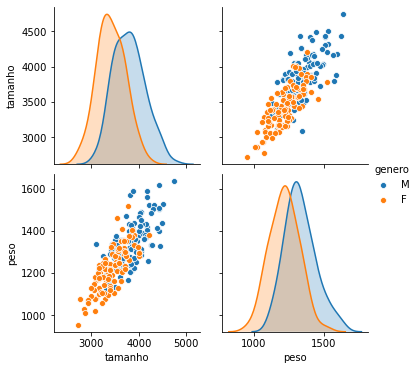

In [6]:
sns.pairplot(brain, vars=['tamanho', 'peso'], hue='genero');

# EXERCÍCIO 1:
1) Há diferença no peso cerebral entre os sexos? E entre os grupos etários? ([TESTE DE HIPÓTESE] H0: há diferença / Ha: não há diferença)

# COMENTÁRIOS
## VALTER
- t-student: antes avalia se a distribuição é normal e depois compara as distribuição
- shapiro-test
- p-valor

---

## SANDY
- verificar se são independentes (teste de Pearson)
- se tem distribuição normal (q-q plot / shapiro)
- tem variâncias iguais (levene)<br>
-> depois disso t-student<br>

Teste T-Student bicaudal

In [7]:
homem_peso =  np.array(brain.loc[brain['homem']==1, 'peso'])
mulher_peso =  np.array(brain.loc[brain['mulher']==1, 'peso'])

acima45_peso =  np.array(brain.loc[brain['acima45']==1, 'peso'])
abaixo45_peso =  np.array(brain.loc[brain['acima45']==0, 'peso'])

## Hipóteses:

**H0**: *NÃO HÁ* diferença entre os pesos cerebrais entre os sexos<br>
**Ha**: *HÁ* diferença entre os pesos cerebrais entre os sexos

Descritiva do Peso - Homem

In [8]:
brain.loc[brain['homem']==1, 'peso'].describe()

count     134.000000
mean     1331.858209
std       108.933390
min      1120.000000
25%      1252.750000
50%      1313.500000
75%      1400.000000
max      1635.000000
Name: peso, dtype: float64

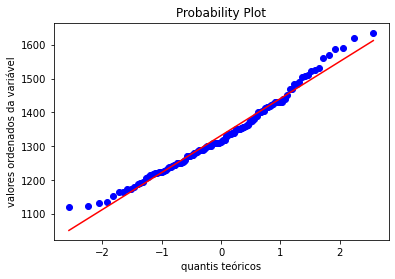

In [9]:
# Gráfico de probabilidade da Normal, para checar suposição de tal distribuição dos dados
stats.probplot(homem_peso, plot=plt)
plt.xlabel('quantis teóricos')
plt.ylabel('valores ordenados da variável')
plt.show()

In [10]:
alpha = 0.05
_, p_value = stats.shapiro(homem_peso)

if p_value > alpha:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que a distribuição é Normal.')
else:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que a distribuição NÃO é Normal.')

Com p_valor de 0.029 assumimos que a distribuição NÃO é Normal.


Descritiva do Peso - Mulher

In [11]:
brain.loc[brain['mulher']==1, 'peso'].describe()

count     103.000000
mean     1219.145631
std       103.829933
min       955.000000
25%      1146.000000
50%      1220.000000
75%      1290.000000
max      1520.000000
Name: peso, dtype: float64

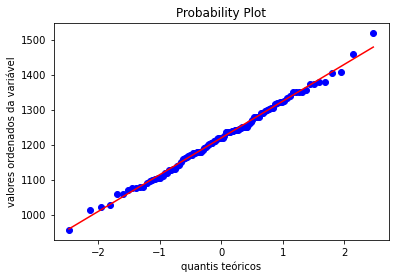

In [12]:
# Gráfico de probabilidade da Normal, para checar suposição de tal distribuição dos dados
stats.probplot(mulher_peso, plot=plt)
plt.xlabel('quantis teóricos')
plt.ylabel('valores ordenados da variável')
plt.show()

In [13]:
alpha = 0.05
_, p_value = stats.shapiro(mulher_peso)

if p_value > alpha:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que a distribuição é Normal.')
else:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que a distribuição NÃO é Normal.')

Com p_valor de 0.992 assumimos que a distribuição é Normal.


Testes de Variância

In [14]:
_, p_value = stats.levene(homem_peso, mulher_peso)

if p_value > alpha:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que as Amostras possuem a mesma Variância.')
else:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que as Amostras NÃO possuem a mesma Variância.')

Com p_valor de 0.767 assumimos que as Amostras possuem a mesma Variância.


Teste de Indenpendencia

In [15]:
s_homem_peso = np.random.choice(homem_peso, 100)
s_mulher_peso = np.random.choice(mulher_peso, 100)

_, p_value = stats.pearsonr(s_homem_peso, s_mulher_peso)

if p_value > alpha:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que as Amostras são Independentes.')
else:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que as Amostras NÃO são Independentes.')

Com p_valor de 0.349 assumimos que as Amostras são Independentes.


Teste de Hipóteses - Sexo

In [16]:
_, p_value = stats.ttest_ind(homem_peso, mulher_peso, equal_var = True)

if p_value > alpha:
    print(f'Com p_valor de {round(p_value, 5)} assumimos que NÃO HÁ diferença entre os pesos cerebrais entre os sexos.')
else:
    print(f'Com p_valor de {round(p_value, 5)} assumimos que HÁ diferença entre os pesos cerebrais entre os sexos.')

Com p_valor de 0.0 assumimos que HÁ diferença entre os pesos cerebrais entre os sexos.


### TESTE PARA A FAIXA ETÁRIA

#### acima 45

In [17]:
brain.loc[brain['acima45']==1, 'peso'].describe()

count     127.000000
mean     1263.937008
std       120.925712
min       955.000000
25%      1180.000000
50%      1250.000000
75%      1332.500000
max      1620.000000
Name: peso, dtype: float64

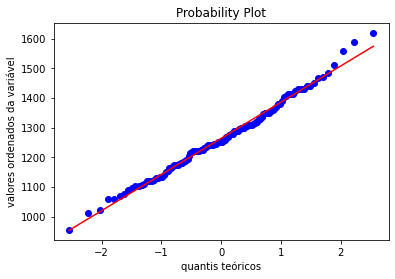

In [18]:
# Gráfico de probabilidade da Normal, para checar suposição de tal distribuição dos dados
stats.probplot(acima45_peso, plot=plt)
plt.xlabel('quantis teóricos')
plt.ylabel('valores ordenados da variável')
plt.show()

In [19]:
alpha = 0.05
_, p_value = stats.shapiro(acima45_peso)

if p_value > alpha:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que a distribuição é Normal.')
else:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que a distribuição NÃO é Normal.')

Com p_valor de 0.655 assumimos que a distribuição é Normal.


#### abaixo 45

In [20]:
brain.loc[brain['acima45']==0, 'peso'].describe()

count     110.000000
mean     1304.736364
std       116.409959
min      1027.000000
25%      1227.500000
50%      1301.000000
75%      1370.750000
max      1635.000000
Name: peso, dtype: float64

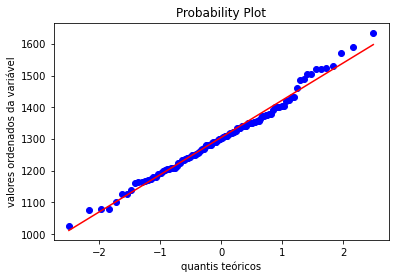

In [21]:
# Gráfico de probabilidade da Normal, para checar suposição de tal distribuição dos dados
stats.probplot(abaixo45_peso, plot=plt)
plt.xlabel('quantis teóricos')
plt.ylabel('valores ordenados da variável')
plt.show()

In [22]:
alpha = 0.05
_, p_value = stats.shapiro(abaixo45_peso)

if p_value > alpha:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que a distribuição é Normal.')
else:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que a distribuição NÃO é Normal.')

Com p_valor de 0.422 assumimos que a distribuição é Normal.


##### teste de variancia - idade

In [23]:
_, p_value = stats.levene(acima45_peso, abaixo45_peso)

if p_value > alpha:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que as Amostras possuem a mesma Variância.')
else:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que as Amostras NÃO possuem a mesma Variância.')

Com p_valor de 0.692 assumimos que as Amostras possuem a mesma Variância.


#### Indepencia - idade

In [24]:
s_acima45_peso = np.random.choice(acima45_peso, 100)
s_abaixo45_peso = np.random.choice(abaixo45_peso, 100)

_, p_value = stats.pearsonr(s_acima45_peso, s_abaixo45_peso)

if p_value > alpha:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que as Amostras são Independentes.')
else:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que as Amostras NÃO são Independentes.')

Com p_valor de 0.292 assumimos que as Amostras são Independentes.


#### Teste de Hipótese - idade

In [25]:
_, p_value = stats.ttest_ind(acima45_peso, abaixo45_peso, equal_var = True)

if p_value > alpha:
    print(f'Com p_valor de {round(p_value, 5)} assumimos que NÃO HÁ diferença entre os pesos cerebrais entre as faixa etárias.')
else:
    print(f'Com p_valor de {round(p_value, 5)} assumimos que HÁ diferença entre os pesos cerebrais entre as faixa etárias.')

Com p_valor de 0.00896 assumimos que HÁ diferença entre os pesos cerebrais entre as faixa etárias.


# RESPOSTA 1:
## HÁ DIFERENÇA ENTRE OS PESOS CEREBRAIS QUANDO AVALIADO O SEXO E AS FAIXAS ETÁRIAS
---

# EXERCÍCIO 2:
2) O tamanho da cabeça é preditor do peso cerebral e, neste caso, há diferença nessa relação entre os sexos e entre os grupos etários? (Regressão Linear)

In [26]:
brain['tamanho_ajustado'] = brain['tamanho'] - np.mean(brain['tamanho'])

brain['tamanho_padronizado'] = (brain['tamanho'] - np.mean(brain['tamanho']))/np.std(brain['tamanho'])

In [27]:
brain.head()

,homem,homem_acima45,mulher,mulher_acima45,genero,tamanho,peso,acima45,tamanho_ajustado,tamanho_padronizado
0,1,0,0,0,M,4512,1530,0,878.008439,2.408868
1,1,0,0,0,M,3738,1297,0,104.008439,0.285353
2,1,0,0,0,M,4261,1335,0,627.008439,1.720235
3,1,0,0,0,M,3777,1282,0,143.008439,0.392352
4,1,0,0,0,M,4177,1590,0,543.008439,1.489776


### todas as variáveis

In [28]:
mod = ols('peso ~ homem + homem_acima45 + tamanho + tamanho_ajustado + mulher + mulher_acima45',data=brain)
res = mod.fit()
print(res.summary())

OLS Regression Results                            
Dep. Variable:                   peso   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     109.4
Date:                Wed, 17 Jun 2020   Prob (F-statistic):           3.05e-52
Time:                        19:40:29   Log-Likelihood:                -1345.5
No. Observations:                 237   AIC:                             2701.
Df Residuals:                     232   BIC:                             2718.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0001   4.35e-06     29.598      0.000       0

In [29]:
y, X = dmatrices('peso ~ homem + homem_acima45 + tamanho + tamanho_ajustado + mulher + mulher_acima45', brain, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

VIF Factor          features
0    0.000000         Intercept
1         inf             homem
2    1.618189     homem_acima45
3         inf           tamanho
4         inf  tamanho_ajustado
5         inf            mulher
6    1.552903    mulher_acima45


### remove *mulher_acima45* por ter p_value > 0.05

In [30]:
mod = ols('peso ~ homem + homem_acima45 + tamanho + tamanho_ajustado + mulher',data=brain)
res = mod.fit()
print(res.summary())

OLS Regression Results                            
Dep. Variable:                   peso   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     145.2
Date:                Wed, 17 Jun 2020   Prob (F-statistic):           4.63e-53
Time:                        19:40:30   Log-Likelihood:                -1346.2
No. Observations:                 237   AIC:                             2700.
Df Residuals:                     233   BIC:                             2714.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0001   4.24e-06     30.092      0.000       0

In [31]:
y, X = dmatrices('peso ~ homem + homem_acima45 + tamanho + tamanho_ajustado + mulher', brain, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

VIF Factor          features
0    0.000000         Intercept
1         inf             homem
2    1.617799     homem_acima45
3         inf           tamanho
4         inf  tamanho_ajustado
5         inf            mulher


### remove *mulher* por ter o mesmo p_value que *homem*

In [32]:
mod = ols('peso ~ homem + homem_acima45 + tamanho + tamanho_ajustado',data=brain)
res = mod.fit()
print(res.summary())

OLS Regression Results                            
Dep. Variable:                   peso   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     145.2
Date:                Wed, 17 Jun 2020   Prob (F-statistic):           4.63e-53
Time:                        19:40:32   Log-Likelihood:                -1346.2
No. Observations:                 237   AIC:                             2700.
Df Residuals:                     233   BIC:                             2714.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0001   3.79e-06     32.906      0.000       0

In [33]:
y, X = dmatrices('peso ~ homem + homem_acima45 + tamanho + tamanho_ajustado', brain, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

VIF Factor          features
0    0.000000         Intercept
1    2.093529             homem
2    1.617799     homem_acima45
3         inf           tamanho
4         inf  tamanho_ajustado


### após a identificação das variáveis importantes foi adicionado as interações

In [34]:
mod = ols('peso ~ homem*tamanho + homem_acima45 + tamanho_ajustado',data=brain)
res = mod.fit()
print(res.summary())

OLS Regression Results                            
Dep. Variable:                   peso   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     109.9
Date:                Wed, 17 Jun 2020   Prob (F-statistic):           2.21e-52
Time:                        19:40:33   Log-Likelihood:                -1345.2
No. Observations:                 237   AIC:                             2700.
Df Residuals:                     232   BIC:                             2718.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0001   5.91e-06     20.032      0.000       0

In [35]:
y, X = dmatrices('peso ~ homem*tamanho + homem_acima45 + tamanho_ajustado', brain, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

VIF Factor          features
0    0.000000         Intercept
1  141.138939             homem
2         inf           tamanho
3  157.945396     homem:tamanho
4    1.637485     homem_acima45
5         inf  tamanho_ajustado


### removido a interação *homem x tamanho* por ter aumentado o p_value e criar multicolinearidade

In [36]:
mod = ols('peso ~ homem * tamanho_ajustado+ tamanho + homem_acima45',data=brain)
res = mod.fit()
print(res.summary())

OLS Regression Results                            
Dep. Variable:                   peso   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     109.9
Date:                Wed, 17 Jun 2020   Prob (F-statistic):           2.21e-52
Time:                        19:40:35   Log-Likelihood:                -1345.2
No. Observations:                 237   AIC:                             2700.
Df Residuals:                     232   BIC:                             2718.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.0001   5.91e-06     20.032 

In [37]:
y, X = dmatrices('peso ~ homem*tamanho_ajustado + homem_acima45 + tamanho', brain, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

VIF Factor                features
0    0.000000               Intercept
1    2.110792                   homem
2         inf        tamanho_ajustado
3    2.931658  homem:tamanho_ajustado
4    1.637485           homem_acima45
5         inf                 tamanho


### removido a interação *homem x tamanho_ajustado* por ter um alto p_value

In [38]:
mod = ols('peso ~ homem_acima45 * tamanho_ajustado + tamanho + homem',data=brain)
res = mod.fit()
print(res.summary())

OLS Regression Results                            
Dep. Variable:                   peso   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     108.5
Date:                Wed, 17 Jun 2020   Prob (F-statistic):           5.61e-52
Time:                        19:40:37   Log-Likelihood:                -1346.1
No. Observations:                 237   AIC:                             2702.
Df Residuals:                     232   BIC:                             2720.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.000

In [39]:
y, X = dmatrices('peso ~ homem_acima45 * tamanho_ajustado + homem + tamanho', brain, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

VIF Factor                        features
0    0.000000                       Intercept
1    1.860663                   homem_acima45
2         inf                tamanho_ajustado
3    1.630650  homem_acima45:tamanho_ajustado
4    2.343717                           homem
5         inf                         tamanho


### removido a interação *homem_acima45 x tamanho_ajustado* por ter um alto p_value

In [40]:
mod = ols('peso ~ homem_acima45 * tamanho + tamanho_ajustado + homem',data=brain)
res = mod.fit()
print(res.summary())

OLS Regression Results                            
Dep. Variable:                   peso   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     108.5
Date:                Wed, 17 Jun 2020   Prob (F-statistic):           5.61e-52
Time:                        19:40:40   Log-Likelihood:                -1346.1
No. Observations:                 237   AIC:                             2702.
Df Residuals:                     232   BIC:                             2720.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0001   4.59e-06     27.456    

In [41]:
y, X = dmatrices('peso ~ homem_acima45 * tamanho + tamanho_ajustado + homem', brain, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

VIF Factor               features
0    0.000000              Intercept
1  149.856158          homem_acima45
2         inf                tamanho
3  146.748308  homem_acima45:tamanho
4         inf       tamanho_ajustado
5    2.343717                  homem


### removido a interação *homem_acima45 x tamanho* por ter aumentado o p_value e criado a Multicolinearidade

## modelo selecionado abaixo:

In [42]:
mod = ols('peso ~ homem + homem_acima45 + tamanho',data=brain)
res = mod.fit()
print(res.summary())

OLS Regression Results                            
Dep. Variable:                   peso   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     145.2
Date:                Wed, 17 Jun 2020   Prob (F-statistic):           4.63e-53
Time:                        19:40:40   Log-Likelihood:                -1346.2
No. Observations:                 237   AIC:                             2700.
Df Residuals:                     233   BIC:                             2714.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       377.3615     51.780      7.288      0.000     275.344     

In [43]:
y, X = dmatrices('peso ~ homem + homem_acima45 + tamanho', brain, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

VIF Factor       features
0  124.296419      Intercept
1    2.093529          homem
2    1.617799  homem_acima45
3    1.385451        tamanho


In [44]:
mod = ols('peso ~ homem + homem_acima45 + tamanho_ajustado',data=brain)
res = mod.fit()
print(res.summary())

OLS Regression Results                            
Dep. Variable:                   peso   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     145.2
Date:                Wed, 17 Jun 2020   Prob (F-statistic):           4.63e-53
Time:                        19:40:42   Log-Likelihood:                -1346.2
No. Observations:                 237   AIC:                             2700.
Df Residuals:                     233   BIC:                             2714.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1271.7430      7.740    164.308      0.000    1256

In [45]:
y, X = dmatrices('peso ~ homem + homem_acima45 + tamanho_ajustado', brain, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

VIF Factor          features
0    2.777259         Intercept
1    2.093529             homem
2    1.617799     homem_acima45
3    1.385451  tamanho_ajustado


In [46]:
mod = ols('peso ~ homem + acima45 + tamanho_ajustado + mulher',data=brain)
res = mod.fit()
print(res.summary())

OLS Regression Results                            
Dep. Variable:                   peso   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     146.0
Date:                Wed, 17 Jun 2020   Prob (F-statistic):           2.94e-53
Time:                        19:40:43   Log-Likelihood:                -1345.7
No. Observations:                 237   AIC:                             2699.
Df Residuals:                     233   BIC:                             2713.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          862.8286      4.550    189.616      0.000     853

In [47]:
y, X = dmatrices('peso ~ homem + acima45 + tamanho_ajustado + mulher', brain, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

VIF Factor          features
0    0.000000         Intercept
1         inf             homem
2    1.040419           acima45
3    1.402975  tamanho_ajustado
4         inf            mulher


In [48]:
mod = ols('peso ~ homem + acima45 + tamanho_ajustado',data=brain)
res = mod.fit()
print(res.summary())

OLS Regression Results                            
Dep. Variable:                   peso   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     146.0
Date:                Wed, 17 Jun 2020   Prob (F-statistic):           2.94e-53
Time:                        19:40:44   Log-Likelihood:                -1345.7
No. Observations:                 237   AIC:                             2699.
Df Residuals:                     233   BIC:                             2713.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1282.9713      8.703    147.412      0.000    1265

In [49]:
y, X = dmatrices('peso ~ homem + acima45 + tamanho_ajustado', brain, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

VIF Factor          features
0    3.525323         Intercept
1    1.398371             homem
2    1.040419           acima45
3    1.402975  tamanho_ajustado


In [50]:
mod = ols('peso ~ homem + acima45 + tamanho_padronizado',data=brain)
res = mod.fit()
print(res.summary())

OLS Regression Results                            
Dep. Variable:                   peso   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     146.0
Date:                Wed, 17 Jun 2020   Prob (F-statistic):           2.94e-53
Time:                        19:40:45   Log-Likelihood:                -1345.7
No. Observations:                 237   AIC:                             2699.
Df Residuals:                     233   BIC:                             2713.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1282.9713      8.703    147.412      0.00

In [51]:
y, X = dmatrices('peso ~ homem + acima45 + tamanho_padronizado', brain, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

VIF Factor             features
0    3.525323            Intercept
1    1.398371                homem
2    1.040419              acima45
3    1.402975  tamanho_padronizado


In [52]:
mod = ols('peso ~ acima45 + homem + tamanho_padronizado',data=brain)
res = mod.fit()
print(res.summary())

OLS Regression Results                            
Dep. Variable:                   peso   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     146.0
Date:                Wed, 17 Jun 2020   Prob (F-statistic):           2.94e-53
Time:                        19:40:46   Log-Likelihood:                -1345.7
No. Observations:                 237   AIC:                             2699.
Df Residuals:                     233   BIC:                             2713.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1282.9713      8.703    147.412      0.00

In [53]:
# Estimativa da variância do erro (sigma2), que é o MSE=SQE/(n-p)
res.mse_resid

5092.320159230041

In [54]:
# valores preditos de E(Y)
ypred=res.fittedvalues

# resíduo=observado-ajustado
residuo = res.resid

# objeto para a análise de pontos influentes
infl = res.get_influence()

# diagonal da matriz hat
hii = infl.hat_matrix_diag

# resíduo studentizado (internamente)
res_stud = infl.resid_studentized_internal

# resíduo studentizado com i-ésima observação deletada (externamente)
res_stud_del = infl.resid_studentized_external

# DFFITS
(dffits,p) = infl.dffits

# Distância de Cook
(cook,p) = infl.cooks_distance

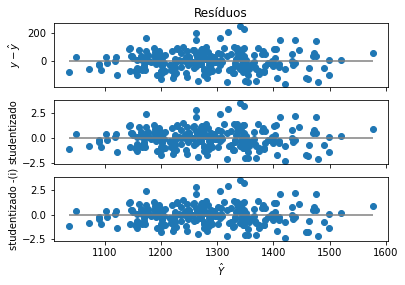

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.scatter(ypred, residuo)
ax1.set_ylabel('$y-\hat{y}$')
ax1.set_title('Resíduos')
ax1.hlines(0,xmin=min(ypred),xmax=max(ypred),color='gray')
ax2.scatter(ypred, res_stud)
ax2.set_ylabel('studentizado')
ax2.hlines(0,xmin=min(ypred),xmax=max(ypred),color='gray')
ax3.scatter(ypred, res_stud_del)
ax3.set_ylabel('studentizado -(i)')
ax3.hlines(0,xmin=min(ypred),xmax=max(ypred),color='gray')
ax3.set_xlabel('$\hat{Y}$')

for ax in fig.get_axes():
    ax.label_outer()

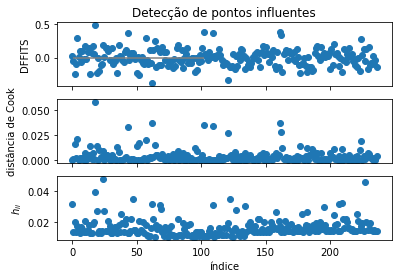

In [56]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.scatter(brain.index, dffits)
ax1.set_ylabel('DFFITS')
ax1.set_title('Detecção de pontos influentes')
ax1.hlines(0,xmin=1,xmax=102,color='gray')
ax2.scatter(brain.index, cook)
ax2.set_ylabel('distância de Cook')
ax3.scatter(brain.index, hii)
ax3.set_ylabel('$h_{ii}$')
ax3.set_xlabel('índice')

for ax in fig.get_axes():
    ax.label_outer()

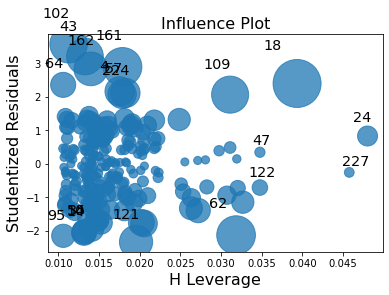

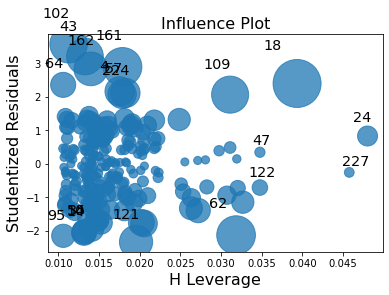

In [57]:
import statsmodels.api as sm

# Gráficos dos resíduos
sm.graphics.influence_plot(res)

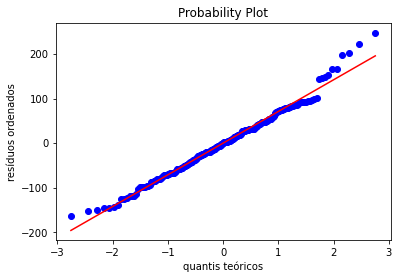

In [58]:
# Verificando a suposição de distribuição Normal dos resíduos
stats.probplot(residuo, plot=plt)
plt.xlabel('quantis teóricos')
plt.ylabel('resíduos ordenados')
plt.show()

In [59]:
alpha = 0.05
_, p_value = stats.shapiro(residuo)

if p_value > alpha:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que a distribuição é Normal.')
else:
    print(f'Com p_valor de {round(p_value, 3)} assumimos que a distribuição NÃO é Normal.')

Com p_valor de 0.021 assumimos que a distribuição NÃO é Normal.


# EXERCÍCIO 3

In [60]:
homem_peso = brain.loc[brain['homem']==1, 'peso']
mulher_peso = brain.loc[brain['mulher']==1, 'peso']

Melhor mu: 1331.5726290516207
Estimativa intervalar para o Peso dos Homens:  (1313.2447792718747, 1350.4716386385733)


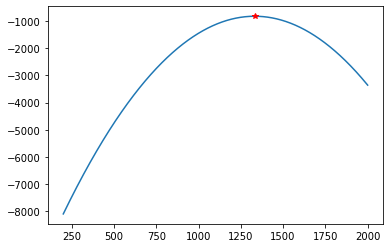

In [64]:
#Conhecendo a forma da função log-verossimilhança da amostra da distribuição Normal
# tomando os dados do peso dos homens, podemos fazer a estimativa da média:
def get_ll_normal(x, mu, sigma):
    return np.sum(np.log(stats.norm.pdf(x, mu, sigma)))

x = homem_peso # iguala x a variável "Media" 
sigma = np.std(x) # # parâmetro fixo, igualado ao desvio padrão amostral
theta = np.linspace(200, 2000, 2500) # parâmetro que vamos variar (mu)
f_theta1 = np.array([get_ll_normal(x, mu, sigma) for mu in theta])

i_best = np.argmax(f_theta1) # cálculo (numérico) do estimador de máxima verossimilhança (EMV) de mu
print('Melhor mu:', theta[i_best])
print("Estimativa intervalar para o Peso dos Homens: ",sms.DescrStatsW(homem_peso).tconfint_mean()) # IC para média de uma Normal (desvio padrão desconhecido)

plt.plot(theta, f_theta1)
plt.plot([theta[i_best]], [f_theta1[i_best]], 'r*'); # coloca uma estrelinha no maior valor (EMV)



Melhor mu: 1219.2076830732294
Estimativa intervalar para o Peso das Mulheres:  (1198.8531509366069, 1239.4381111993155)


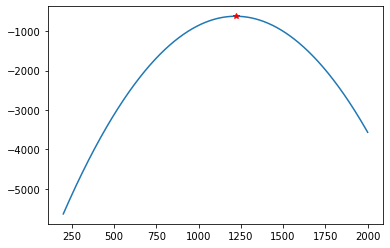

In [66]:
#Conhecendo a forma da função log-verossimilhança da amostra da distribuição Normal
# tomando os dados do peso dos homens, podemos fazer a estimativa da média:
def get_ll_normal(x, mu, sigma):
    return np.sum(np.log(stats.norm.pdf(x, mu, sigma)))

x = mulher_peso # iguala x a variável "Media" 
sigma = np.std(x) # # parâmetro fixo, igualado ao desvio padrão amostral
theta = np.linspace(200, 2000, 2500) # parâmetro que vamos variar (mu)
f_theta1 = np.array([get_ll_normal(x, mu, sigma) for mu in theta])

i_best = np.argmax(f_theta1) # cálculo (numérico) do estimador de máxima verossimilhança (EMV) de mu
print('Melhor mu:', theta[i_best])
print("Estimativa intervalar para o Peso das Mulheres: ",sms.DescrStatsW(mulher_peso).tconfint_mean()) # IC para média de uma Normal (desvio padrão desconhecido)

plt.plot(theta, f_theta1)
plt.plot([theta[i_best]], [f_theta1[i_best]], 'r*'); # coloca uma estrelinha no maior valor (EMV)
